In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

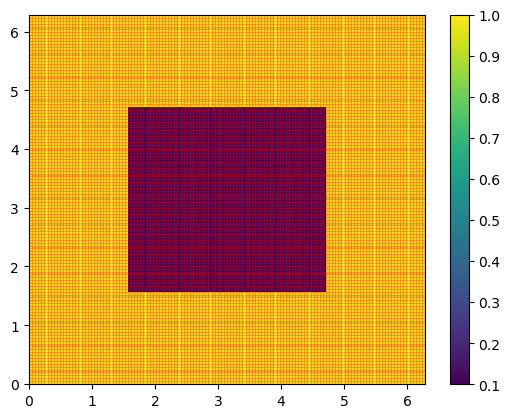

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [4]:
N_test = 100
torch.manual_seed(0)
test_functions = [PINN_softsign(n_periodic=10, n_hidden=20, n_layers=3, period_len=L).to(dev) for i in range(N_test)]

In [5]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

#for i in range(N_test):
    #for j in range(i, N_test):
        #intgr = compute_int(areas, tri, g_test[i], g_test[j])
        #G[i,j] = intgr
        #G[j,i] = intgr

for i in range(N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
        G[i,i] = intgr

torch.save(G, "G_sofsign_65.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [9]:
G = torch.load("G_sofsign_65.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

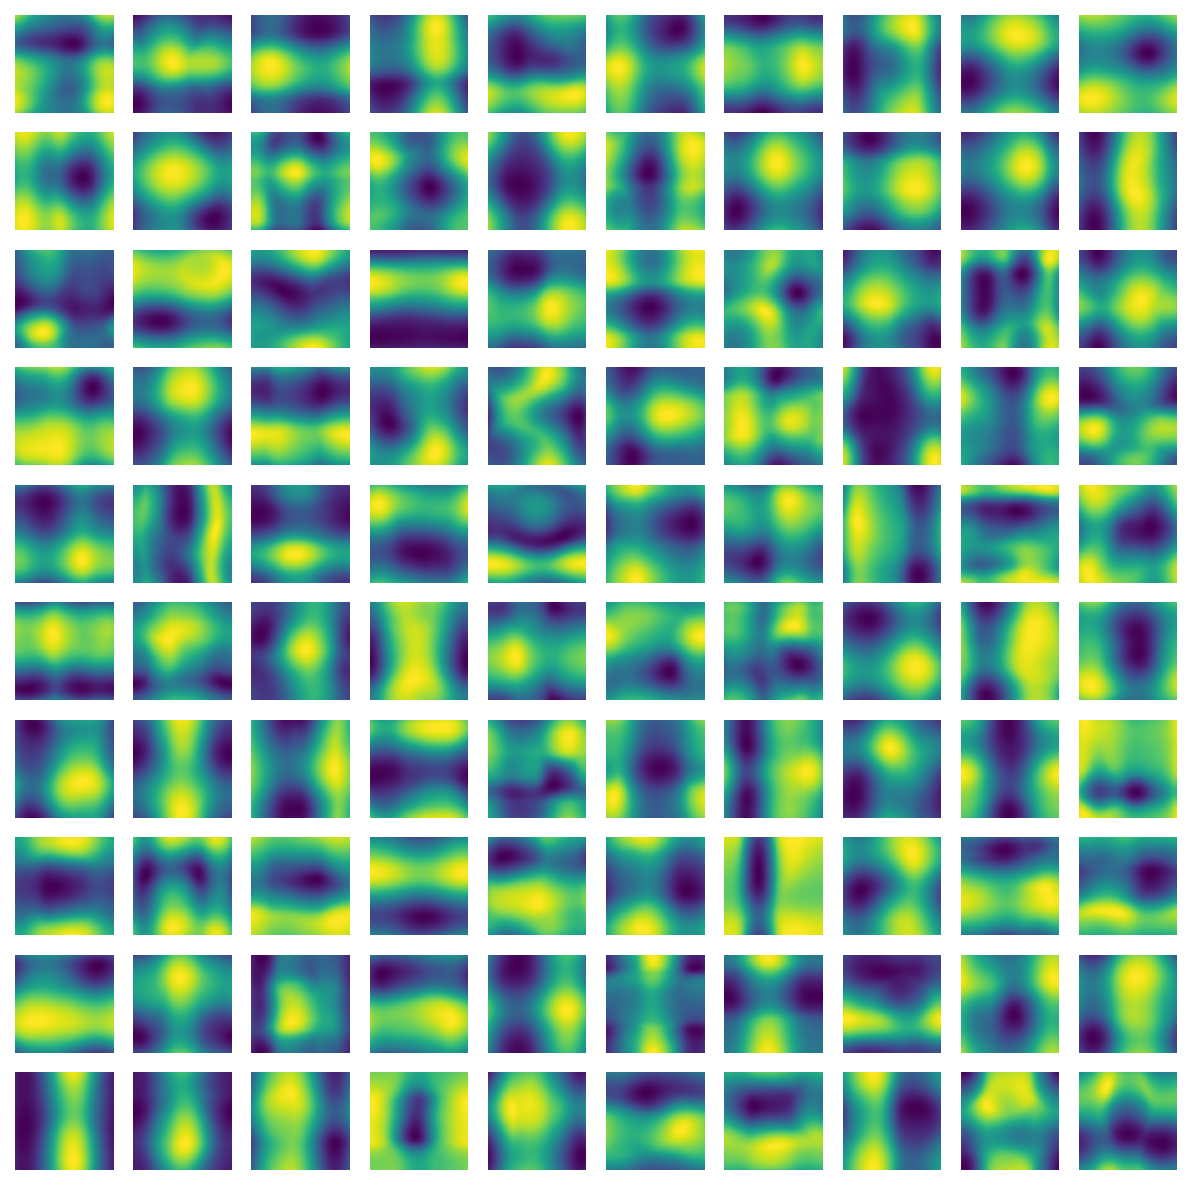

In [10]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [11]:
net_primal = PINN_softsign(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNSSPINN_primal_{total_params}_{N_test}'}

Number of parameters: 1801


In [ ]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [18]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  1.07719297e+01, mean val. loss:  7.66774595e-01
Epoch: 1 mean train loss:  1.05456114e+01, mean val. loss:  7.66440272e-01
Epoch: 2 mean train loss:  1.03219604e+01, mean val. loss:  7.66110122e-01
Epoch: 3 mean train loss:  1.01010475e+01, mean val. loss:  7.65785038e-01
Epoch: 4 mean train loss:  9.88294792e+00, mean val. loss:  7.65464425e-01
Epoch: 5 mean train loss:  9.66778946e+00, mean val. loss:  7.65148759e-01
Epoch: 6 mean train loss:  9.45562744e+00, mean val. loss:  7.64838517e-01
Epoch: 7 mean train loss:  9.24656200e+00, mean val. loss:  7.64533699e-01
Epoch: 8 mean train loss:  9.04068947e+00, mean val. loss:  7.64234185e-01
Epoch: 9 mean train loss:  8.83809090e+00, mean val. loss:  7.63940096e-01
Epoch: 10 mean train loss:  8.63884354e+00, mean val. loss:  7.63651252e-01
Epoch: 11 mean train loss:  8.44305515e+00, mean val. loss:  7.63367772e-01
Epoch: 12 mean train loss:  8.25073624e+00, mean val. loss:  7.63089955e-01
Epoch: 13 mean train l

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 62.25 GiB is allocated by PyTorch, and 8.21 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
np.save(f'NN_library/training_data/square/VNSSPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

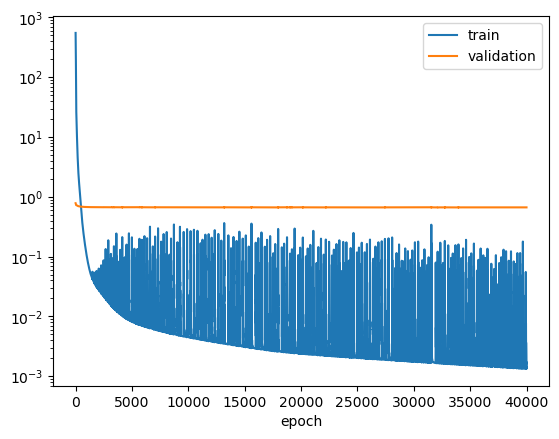

In [12]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [47]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

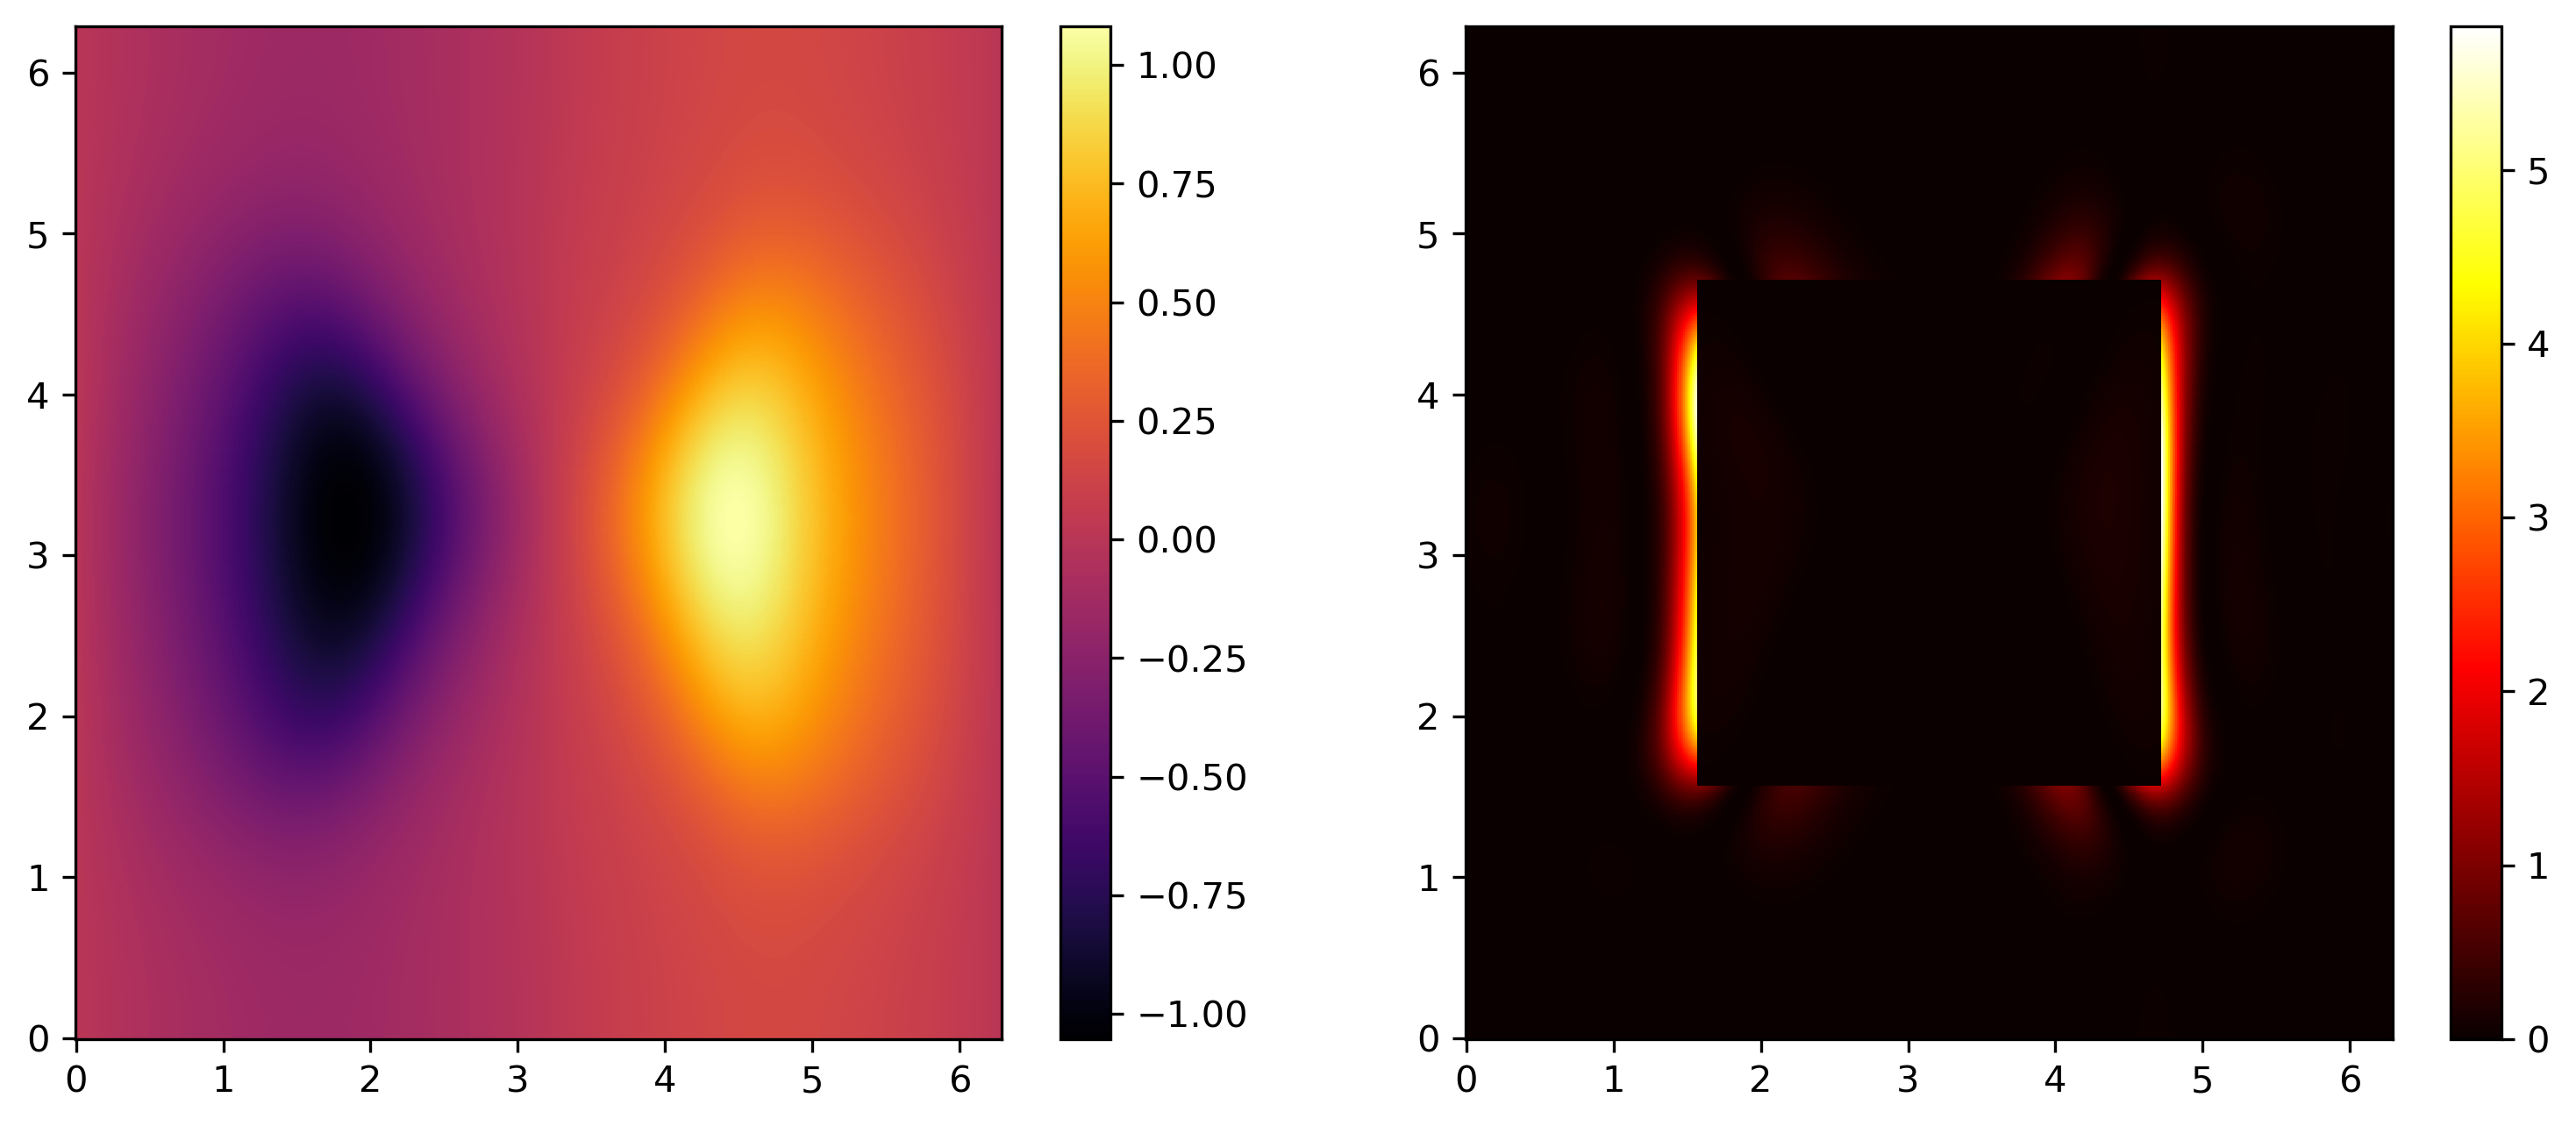

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])

In [ ]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss(x, net_primal, A, H1)
bound = compute_bound(areas, tri, q, L).detach()[0].item()
print(bound)

np.save(f'bounds/square/A_u_VNSSPINN_{total_params}_{N_test}.npy', bound)

0.6682454347610474


# Dual PINN

In [6]:
net_dual = PINN_softsign(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNSSPINN_dual_{total_params}_{N_test}'}

Number of parameters: 1801


In [12]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [7]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  3.99922900e+03, mean val. loss:  2.96770662e-01
Epoch: 1 mean train loss:  3.96686450e+03, mean val. loss:  2.97861040e-01
Epoch: 2 mean train loss:  3.93486182e+03, mean val. loss:  2.98946470e-01
Epoch: 3 mean train loss:  3.90323096e+03, mean val. loss:  3.00027013e-01
Epoch: 4 mean train loss:  3.87195898e+03, mean val. loss:  3.01102281e-01
Epoch: 5 mean train loss:  3.84102344e+03, mean val. loss:  3.02173167e-01
Epoch: 6 mean train loss:  3.81042017e+03, mean val. loss:  3.03239882e-01
Epoch: 7 mean train loss:  3.78015820e+03, mean val. loss:  3.04301083e-01
Epoch: 8 mean train loss:  3.75021387e+03, mean val. loss:  3.05358410e-01
Epoch: 9 mean train loss:  3.72057471e+03, mean val. loss:  3.06411892e-01
Epoch: 10 mean train loss:  3.69123413e+03, mean val. loss:  3.07461262e-01
Epoch: 11 mean train loss:  3.66217676e+03, mean val. loss:  3.08507502e-01
Epoch: 12 mean train loss:  3.63340967e+03, mean val. loss:  3.09550166e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/square/VNSSPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

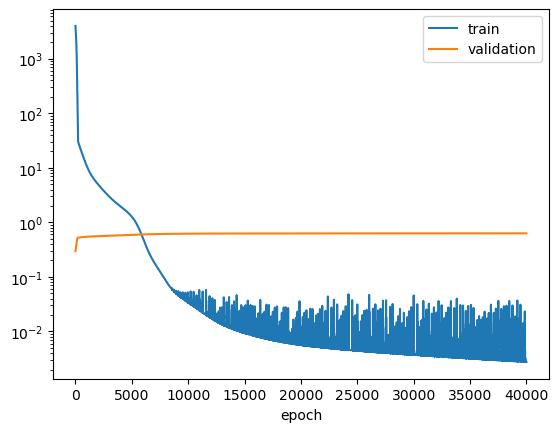

In [8]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [56]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

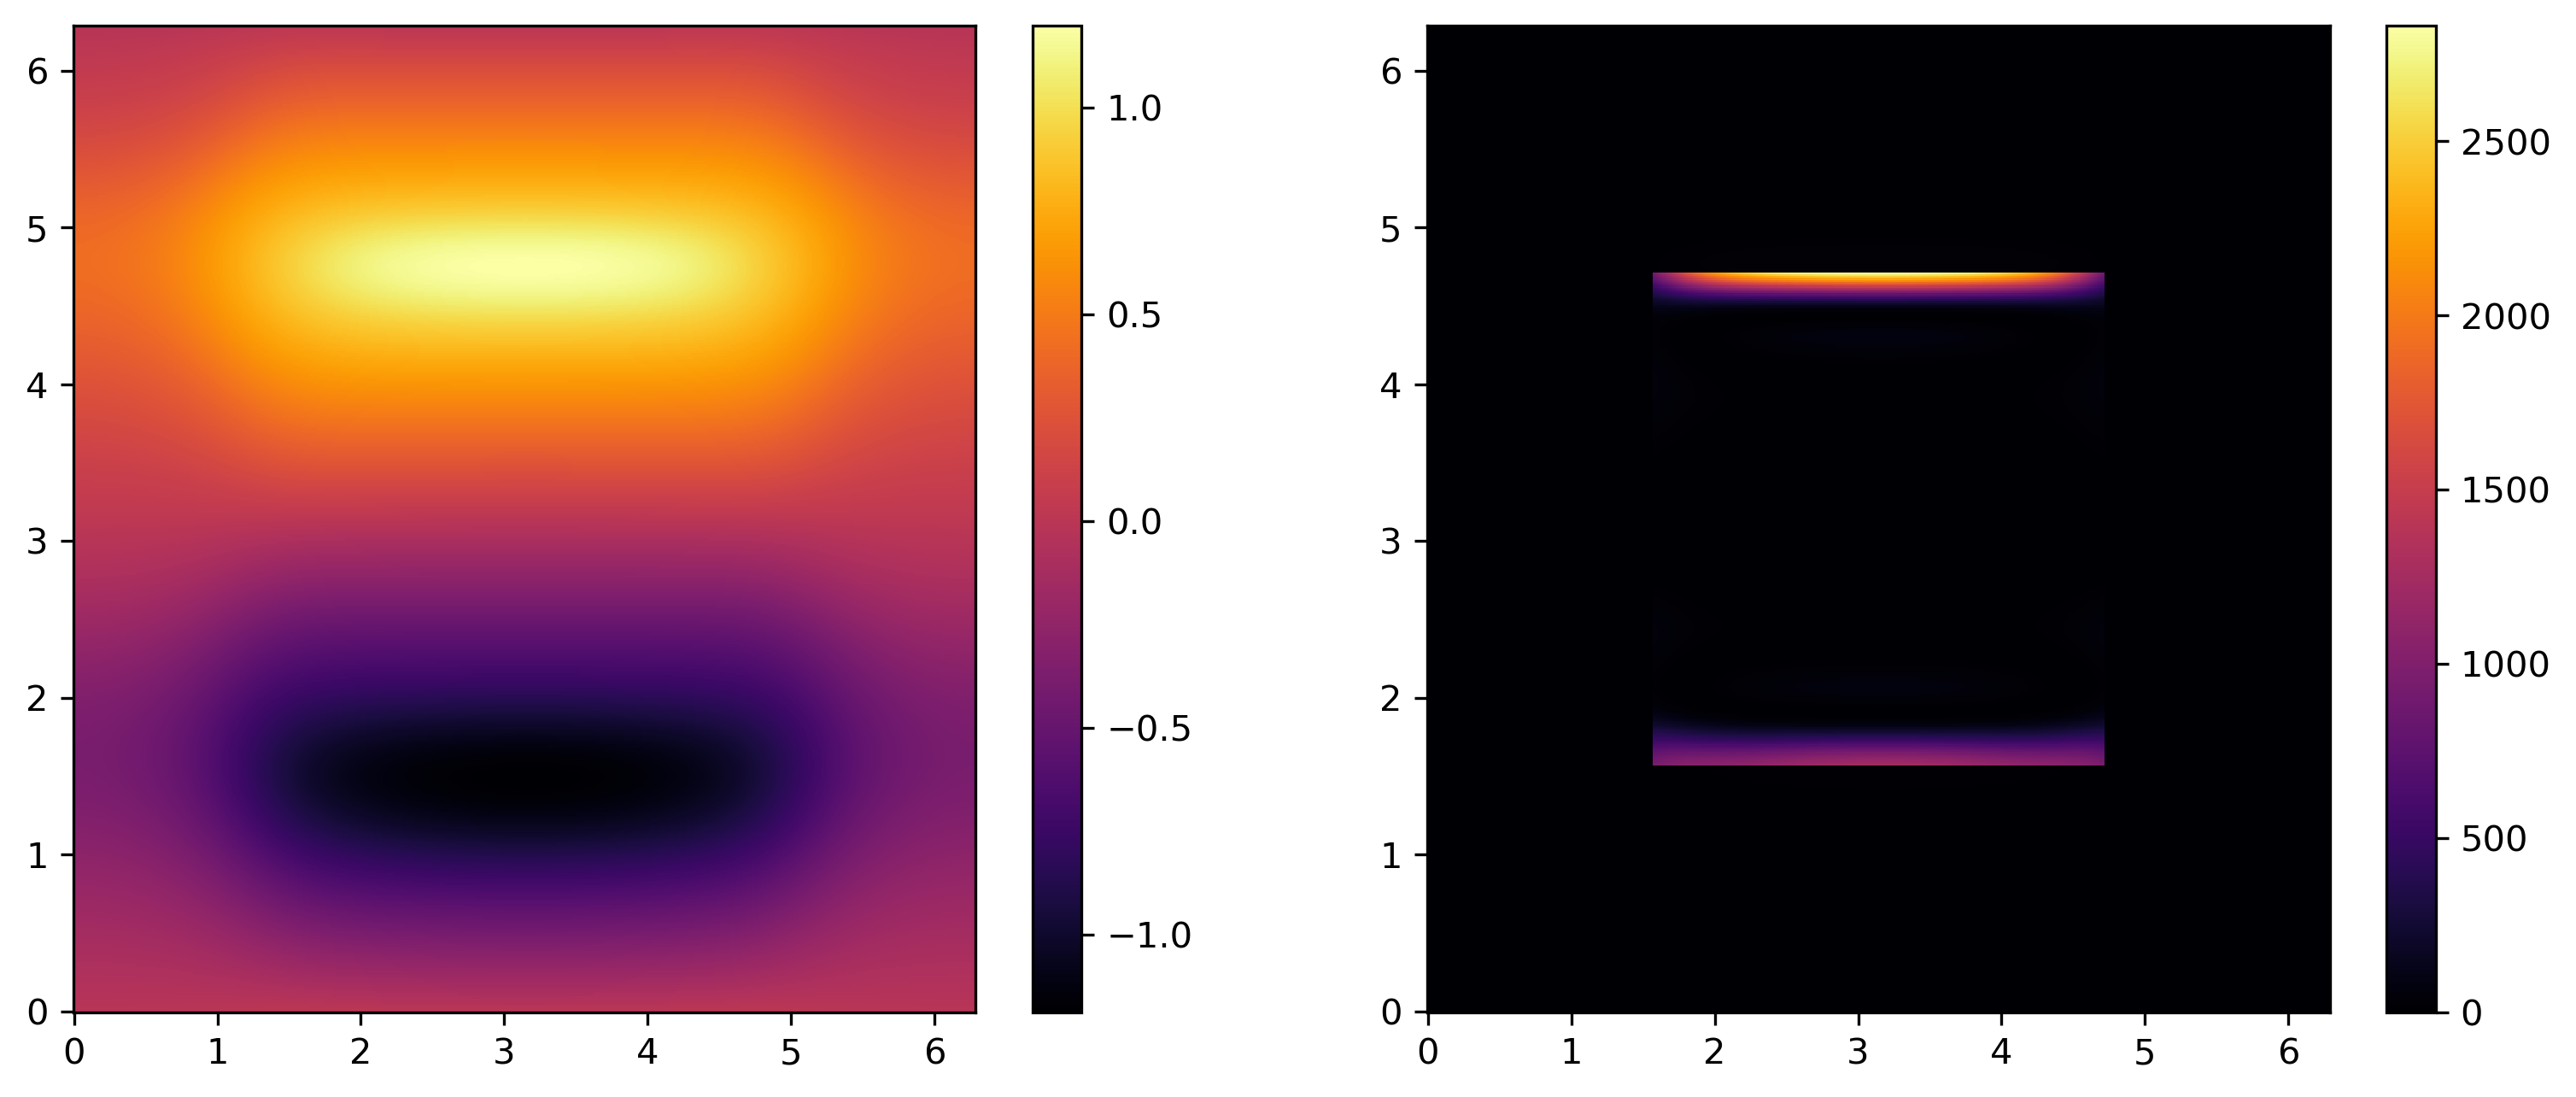

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

In [ ]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss_dual(x, net_dual, A_inv, H1)
bound = compute_bound(areas, tri, q, L).detach()
bound_inv = bound[0] / (bound[0]**2 - bound[1]**2)
print(bound_inv)

np.save(f'bounds/square/A_l_VNSSPINN_{total_params}_{N_test}.npy', bound_inv.item())

tensor(0.6238, device='cuda:0')
